# Exploring bias_aware_grid_search in a finance context: UCI income dataset

The issue of income disparity between genders has long been a prominent social concern, with historical evidence highlighting its persistence through decades. This enduring inequality reflects not just in the realm of salaries and wages, but also in opportunities, career progression, and representation in high-paying industries and roles. Despite legislative and societal efforts to narrow this gap, the disparity continues to be a significant challenge.

Through the lens of the UCI Income Dataset, this notebook investigates how a bias-aware grid search could yield a model that is not only accurate but also fairer in its predictions and implications. By doing so, we aim to showcase the importance of incorporating fairness and bias-awareness in analytical models, especially in sensitive and impactful domains like finance and socio-economic studies. This exploration is a step towards creating more inclusive and equitable analytical practices that recognize and address gender-based income disparities.

In [1]:
# import basic necessities
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import OneHotEncoder
import yaml
import os
import sys

# retrieve data
from ucimlrepo import fetch_ucirepo, list_available_datasets

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# import train test
from sklearn.model_selection import train_test_split

sns.set_theme(style="darkgrid")

In [71]:
# import custom methods
import sys
sys.path.insert(0, '../')

from util import calculate_disparate_impact, calculate_statistical_parity_difference
from bias_aware_gridsearch import BiasAwareGridSearchCV

## Data Processing

In [77]:
# read in data, format to be regular df
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets
adults_df_raw = pd.concat([X,y], axis=1)
adults_df = adults_df_raw.copy()

In [81]:
# encode output variable to binary
adults_df['income'] = adults_df['income'].apply(lambda x: 1 if '>' in x else 0)

In [82]:
# filter for only US entries
adults_df = adults_df[adults_df['native-country']=='United-States']

## Missingness

In [66]:
adults_df.replace('?', np.nan, inplace=True)

In [67]:
adults_df.isna().sum()

age                  0
workclass         2530
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2540
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income               0
dtype: int64

In [68]:
adults_df.shape

(43832, 15)

In [69]:
adults_df = adults_df.dropna()

In [70]:
adults_df.shape

(41292, 15)

Missingness within the dataset is very constrained, representing a very minimal portion of total data. Additionally, all missingness originates from workclass and occupation. It seems that dropping these missing columns would not be very consequential due to the affected column being directly indicative of the output column (that is, the job you work is probably the largest factor in your income). Based on this justification, we opt to drop missingness instead of imputing values.

## EDA

### Source Info

In [9]:
adult.metadata.abstract

'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. '

In [10]:
adult.metadata.repository_url

'https://archive.ics.uci.edu/dataset/2/adult'

### Basic Descriptive Statistics

In [13]:
adults_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,42958.000000,4.295800e+04,42958.000000,42958.000000,42958.000000,42958.000000,42958.000000
mean,38.696401,1.872452e+05,10.186810,1105.282811,88.876787,40.620420,0.752689
std,13.633856,1.051209e+05,2.391466,7513.452483,405.926451,12.336794,0.431454
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.158060e+05,9.000000,0.000000,0.000000,40.000000,1.000000
50%,37.000000,1.766930e+05,10.000000,0.000000,0.000000,40.000000,1.000000
75%,48.000000,2.346400e+05,12.000000,0.000000,0.000000,45.000000,1.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


#### Plots

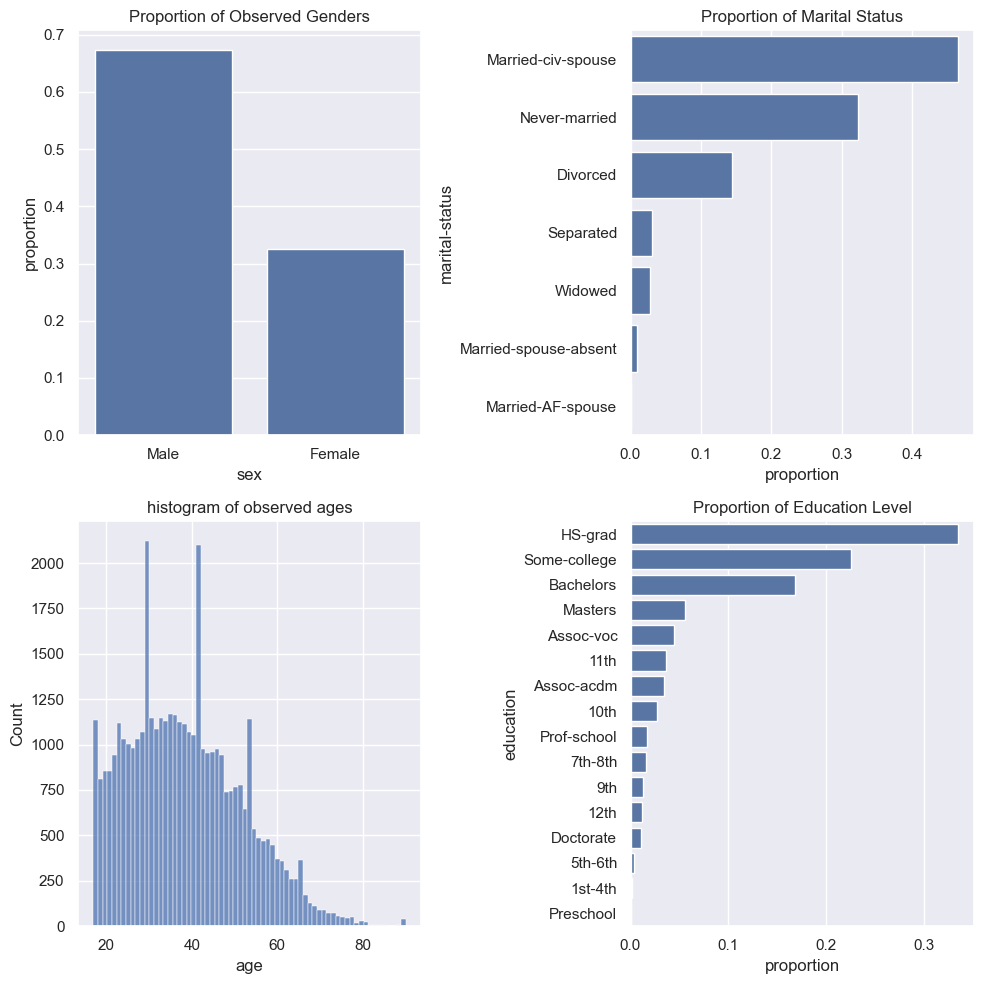

In [72]:
# Create 2x2 axis for plots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# prop of sex plot
prop_sex = adults_df['sex'].value_counts(normalize=True)
prop_sex_df = pd.DataFrame({'sex': prop_sex.index, 'proportion': prop_sex.values})
sns.barplot(data=prop_sex_df, x='sex', y='proportion', ax=axes[0,0])
axes[0, 0].set_title("Proportion of Observed Genders")

# prop of marital status plot
prop_marital = adults_df['marital-status'].value_counts(normalize=True)
prop_marital_df = pd.DataFrame({'marital-status': prop_marital.index, 'proportion': prop_marital.values})
sns.barplot(data=prop_marital_df, y='marital-status', x='proportion', ax=axes[0,1])
axes[0, 1].set_title("Proportion of Marital Status")

# prop of education level plot
prop_education = adults_df['education'].value_counts(normalize=True)
prop_education_df = pd.DataFrame({'education': prop_education.index, 'proportion': prop_education.values})
sns.barplot(data=prop_education_df, y='education', x='proportion', ax=axes[1,1])
axes[1,1].set_title("Proportion of Education Level")

# age plot
sns.histplot(adults_df['age'], ax=axes[1,0])
axes[1,0].set_title('histogram of observed ages')

# Show the plot
plt.tight_layout()
plt.show()

From the above plots we can see that:

1. The majority of our observations are male (70:30 split roughly)
2. almost 50% are married, 30% single, 15% divorced, with the last 5% being from various other categories
3. most observations are within the working age range (20s - 50s)
4. more than half of the observations have completed high school or above

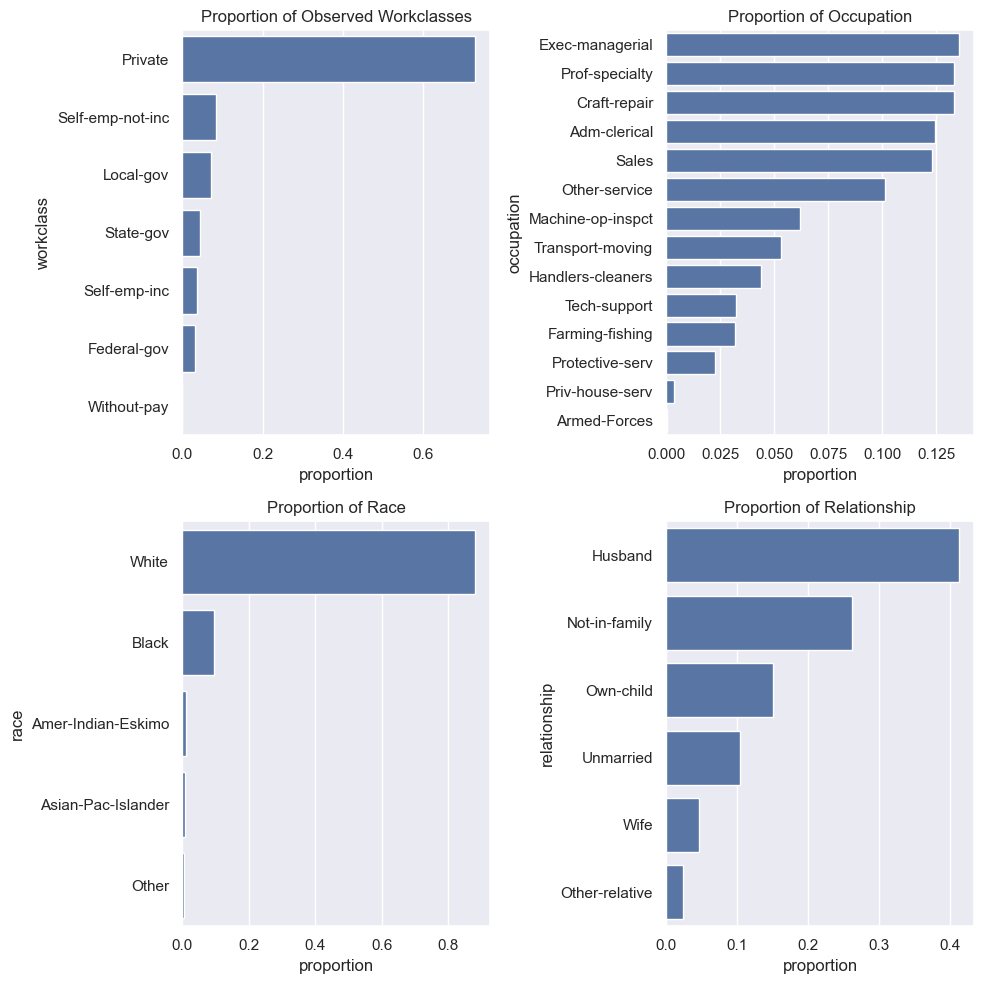

In [73]:
# Create 2x2 axis for plots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# prop of work class plot
prop_class = adults_df['workclass'].value_counts(normalize=True)
prop_class_df = pd.DataFrame({'workclass': prop_class.index, 'proportion': prop_class.values})
sns.barplot(data=prop_class_df, y='workclass', x='proportion', ax=axes[0,0])
axes[0, 0].set_title("Proportion of Observed Workclasses")

# prop of occupation plot
prop_occupation = adults_df['occupation'].value_counts(normalize=True)
prop_occupation_df = pd.DataFrame({'occupation': prop_occupation.index, 'proportion': prop_occupation.values})
sns.barplot(data=prop_occupation_df, y='occupation', x='proportion', ax=axes[0,1])
axes[0, 1].set_title("Proportion of Occupation")

# prop of relationship plot
prop_relationship = adults_df['relationship'].value_counts(normalize=True)
prop_relationship_df = pd.DataFrame({'relationship': prop_relationship.index, 'proportion': prop_relationship.values})
sns.barplot(data=prop_relationship_df, y='relationship', x='proportion', ax=axes[1,1])
axes[1,1].set_title("Proportion of Relationship")

# prop of race plot
prop_race = adults_df['race'].value_counts(normalize=True)
prop_race_df = pd.DataFrame({'race': prop_race.index, 'proportion': prop_race.values})
sns.barplot(data=prop_race_df, y='race', x='proportion', ax=axes[1,0])
axes[1,0].set_title("Proportion of Race")

# Show the plot
plt.tight_layout()
plt.show()

From the above plots we can see that:

1. The majority of our observations work in private sector jobs
2. There is a diverse set of careers observed
3. An overwhelming majority of observations are White (85%!!!)
4. In relation to the gender breakdown, many are husbands

From this quick glance at the data, we can see that sex is probably the most "correctable" contributing factor to income differentials. Though race seems like a prime target to de-bias, the very minimal representation of all other races makes it a more righteous than scientific exercise. Other variables seem to be indicative of the outcome by natural circumstance (ex. higher education correlates to higher pay) or they are related to sex. 

# Model Creation

Before creating any models, we first need to process our data. For our task, we need to one hot encode categorical columns to facilitate numerical inputs for training. Along with this, we will drop the columns 'education' and 'native-country'. Education is encoded in a different column 'education-num' and 'native-country' is meaningless since we previously filtered our observations to only those from the United States.

In [84]:
# Specify the columns to encode
columns_to_encode = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')

# Fit and transform the specified columns and convert to DataFrame
encoded_columns = pd.DataFrame(encoder.fit_transform(adults_df[columns_to_encode]))

# Get the new column names from the encoder
encoded_columns.columns = encoder.get_feature_names_out(columns_to_encode)

# Reset the index of original DataFrame to allow for concatenation
adults_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame (minus the columns to encode) with the new encoded columns
df_encoded = pd.concat([adults_df.drop(columns_to_encode, axis=1), encoded_columns], axis=1)

In [85]:
# drop unecessary columns
df_encoded = df_encoded.drop(columns=['education', 'native-country'])

Before beginning our model building, let's just see what the "total" disparate impact of our encoded dataset is.

In [86]:
calculate_disparate_impact(df_encoded, 'income', 'sex_Male', True, False)

0.6446919880022911

## Naive Model Selection

In a "Naive" model creation pipeline, once the data is prepared, the model is loaded into a parameter searching function such as sklearn's GridsearchCV, then the highest accuracy model is selected based on the result. For the purposes of this exercise, let's begin with this standard pipeline.

In [19]:
# split into input/output variables
X = df_encoded.drop(columns=['income'])
y = df_encoded['income']

In [20]:
# train test split, seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Naive Model Building

In [22]:
# load in params
parent_dir = os.path.dirname(os.getcwd())
params_path = os.path.join(parent_dir, 'params.yaml')

with open(params_path, 'r') as file:
    param_grid_file = yaml.safe_load(file)

In [23]:
param_grid_file['detailed_rfc_params']

{'n_estimators': [50, 100, 200, 500],
 'max_depth': [20, 40, 50, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_leaf_nodes': [20, 30, 40, 50, 100],
 'class_weight': ['balanced', 'balanced_subsample']}

In [24]:
# Settings to test
param_grid = param_grid_file['detailed_rfc_params']

rfc = RandomForestClassifier(random_state=42)
clf = GridSearchCV(rfc,param_grid, n_jobs=-2)
clf.fit(X_train, y_train)

best_parameters = clf.best_params_
best_score = clf.best_score_
best_model = clf.best_estimator_

joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

### Model Evaluation

In [25]:
loaded_model = joblib.load('best_model.pkl')

In [26]:
temp = pd.concat([X_train,y_train], axis=1)

In [28]:
calculate_disparate_impact(temp, 'income', 'sex_Male', True, False)

-0.2940138234177516

In [29]:
y_pred = loaded_model.predict(X_train)

In [30]:
temp = X_test.copy().reset_index().drop(columns=['index'])

In [31]:
temp['y_pred'] = pd.Series(y_pred)

In [47]:
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.015244284730120627

## Bias Aware Model Selection

In [33]:
param_grid = param_grid_file['detailed_rfc_params']

In [35]:
estimator = RandomForestClassifier(random_state=42)
grid_search = BiasAwareGridSearchCV(
    estimator, param_grid, df_encoded, 'income', 'sex_Male', True, False, verbose=False)

In [37]:
grid_search.fit(X_train, y_train, calculate_disparate_impact)

In [38]:
joblib.dump(grid_search, 'grid_serach_results.pkl')

['grid_serach_results.pkl']

In [39]:
highest_acc_rfc_bgs = RandomForestClassifier()
highest_acc_rfc_bgs.set_params(**max(grid_search.results_, key=lambda x: x['accuracy'])['params'])
highest_acc_rfc_bgs.fit(X_train, y_train)
joblib.dump(highest_acc_rfc_bgs, 'highest_acc_bgs.pkl')

['highest_acc_bgs.pkl']

In [40]:
temp = X_test.copy().reset_index().drop(columns=['index'])
temp['y_pred'] = pd.Series(highest_acc_rfc_bgs.predict(X_train))
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.014906575638471087

In [41]:
lowest_bias_rfc_bgs = RandomForestClassifier()
lowest_bias_rfc_bgs.set_params(**min(grid_search.results_, key=lambda x: np.abs(x['bias']))['params'])
lowest_bias_rfc_bgs.fit(X_train, y_train)
joblib.dump(lowest_bias_rfc_bgs, 'lowest_bias_bgs.pkl')

['lowest_bias_bgs.pkl']

In [42]:
temp = X_test.copy().reset_index().drop(columns=['index'])
temp['y_pred'] = pd.Series(lowest_bias_rfc_bgs.predict(X_train))
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.013676415690247912

In [43]:
balanced_rfc_bgs = RandomForestClassifier()
top_accurate_models = sorted(grid_search.results_, key=lambda x: x['accuracy'], reverse=True)[:25]
balanced_rfc_bgs.set_params(**min(top_accurate_models, key=lambda x: np.abs(x['bias']))['params'])
balanced_rfc_bgs.fit(X_train, y_train)
joblib.dump(balanced_rfc_bgs, 'balanced_bgs.pkl')

['balanced_bgs.pkl']

In [44]:
temp = X_test.copy().reset_index().drop(columns=['index'])
temp['y_pred'] = pd.Series(balanced_rfc_bgs.predict(X_train))
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.010904429744946098

In [45]:
optimum_rfc_bgs = RandomForestClassifier()

max_accuracy = max(result['accuracy'] for result in grid_search.results_)

# Filter models within the specified margin of the highest accuracy
eligible_models = [result for result in grid_search.results_ if result['accuracy'] >= max_accuracy - 0.1]

# Select the model with the least bias among these
best_model = min(eligible_models, key=lambda x: np.abs(x['bias']))

optimum_rfc_bgs.set_params(**best_model['params'])
optimum_rfc_bgs.fit(X_train,y_train)

joblib.dump(optimum_rfc_bgs, 'optimum_bgs.pkl')

['optimum_bgs.pkl']

In [46]:
temp = X_test.copy().reset_index().drop(columns=['index'])
temp['y_pred'] = pd.Series(optimum_rfc_bgs.predict(X_train))
calculate_disparate_impact(temp, 'y_pred', 'sex_Male', True, False)

0.015244284730120627

## Comparison

## Conclusion